# Unsupervised Temporal Sentiment Clustering of Skilling-J Email Data Set

## Abstract

In this notebook I explore the assigned Skilling-J email dataset. Findings include two sets of anomalies likely the result of software error, as well as several statistically and semantically distinct groupings. These findings culminate in the partitioning of the `./data/skilling-j/inbox/` directory into two distict clusters defined by the directional trend of sentiment over time. Interestingly, the temporal boundary between the upward-trending sentimental cluster-series and the subsequent downward-trending cluster-series appears to coincide within three days of when former Enron CEO Jeffrey Skilling would have given his two-week notice.

## Background & Initial Observations

Based on file contents, the `./data/skilling-j` dataset appears to be the contents of former Enron CEO and convicted felon Jeffrey Skilling. Emails contain text body and metadata and are stored in several apparently meaningfully named directories. Although this project arrives at a thematically satisfying conclusion, I did not set out to prove any specific hypothesis. Rather given limited time, I chose at every conjectural juncture to pursue the exploratory branch most likely to yield interesting results relating to clustering and anomaly detection. 

## Methods

Here is a preview of the libraries we will be using.

In [1]:
import os
import email
import pandas as pd
import pandas_profiling
import datetime as dt
import numpy as np
import nltk
from pdb import set_trace
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,6) # Fit plots to your screen
import ruptures

SECONDS_IN_A_DAY = 24*60*60

## Data cleaning

First, we parse all files in the `./data/skilling-j/` directory into a dataframe, extracting metadata using the built in `email` library. We will use the file path as a unique index. Running this cell should take about 45 seconds.

In [2]:
def get_emails_df():
    emails_df = pd.DataFrame()
    errors = 0
    print("Files with errors:")
    for root, dirs, files in os.walk(r"./data/skilling-j/"):
        unhidden_files = [f for f in files if not f[0] == '.'] # Ignore hidden files

        # Four files are not in UTF-8. None of them are interesting. Leave them out of the data set.
        for f in unhidden_files:
            path = os.path.join(root, f)
            try: # Ignore files not encoded in UTF-8
                message = email.message_from_file(open(path))
            except UnicodeDecodeError as e:
                errors += 1
                print(path)
            else:
                df_row = dict(message)
                df_row['Dir'] = root
                df_row['Filename'] = f
                df_row['Path'] = path # Will serve as primary key (index)
                df_row['Email'] = message
                emails_df = emails_df.append(df_row, ignore_index=True)
    print('error count:', errors)
    emails_df = emails_df.set_index('Path')
    return emails_df

emails_df = get_emails_df()

Files with errors:
./data/skilling-j/notes_inbox/100.
./data/skilling-j/deleted_items/346.
./data/skilling-j/discussion_threads/306.
./data/skilling-j/all_documents/385.
error count: 4


## Anomalies I

We have already discovered our first anomaly! Four files appear not to be encoded in UTF-8 and so are inconvenient to parse. Reading the contents, it appears that two contain an accented Spanish character and one was sent by a disgruntled Japanese employee, whose email client likely defaulted to a Japanese-friendly encoding. The fourth I am not clear what the issue is. This is a startup and you gave me 96 hours, so we're just going to drop them from the data set instead of figuring out how to decode them properly.


## Feature Extraction

Next, let's add some features to our emails dataframe. In practice, features were added via an "Agile" methodology and were definitely *not* made up as I went along.

The features are:

> Feature | Description | Utility <br>
> Datetime | The date the email was sent | Temporal analysis <br>
> Timezone | UTC Timezone | Useful for geolocating. Unused due to time constraint <br>
> Body | The body of the email | Obvious <br>
> Raw body length | number of characters in the email body | Exploratory <br>
> Days since start | Number of days since earliest email sent | Often more convenient than Datetime <br>
> Tokens | Tokenized version of Body | Exploratory <br>
> Neg/Neu/Pos/Com Polarity | Negative, neutral, positive, and compound sentiment polarity as computed by pretrained VADER

Of these features, `Days since start` and `Polarity` turned out to be the most interesting. We will be using `Days since start` in order to plot the change in features over time. Polarity will be used as a general proxy of the emotional state of Jeffrey Skilling and his colleagues. VADER was chosen for this task because it is pre-trained and reasonably well validated. Since it was trained on internet message boards and chats where emotional range is typically more expressive than in workplace emails at large, conservative companies, we should expect to see relatively low negative and positive polarity but relatively high neutral polarity. As such we should consider small changes to positive and negative polarity somewhat more sensitively in this upcoming analysis.

Running this cell should take around 20 seconds.

In [3]:
# Design commentary:
# Redundant features is programmer-friendly but not memory-efficient
# Dataframe manipulation functions adhere to Pandas convention and return a copy, rather than edit in place

def engineer_features(df):
    def _str_to_date(date_str):
        format_str='%a, %d %b %Y %H:%M:%S %z'
        return dt.datetime.strptime(date_str[:-6], format_str) # :-6 to strip redundant UTC codes
    def _apply_sentilizer(body):
        polarities = sentilizer.polarity_scores(body).values()
        return polarities

    from nltk.tokenize import WordPunctTokenizer
    tokenizer = WordPunctTokenizer()
    from nltk.sentiment import SentimentIntensityAnalyzer
    sentilizer = SentimentIntensityAnalyzer()

    pol_cols = ['Neg_pol', 'Neu_pol', 'Pos_pol', 'Com_pol']

    # Make some features
    df['Datetime'] = df['Date'].apply(_str_to_date)
    df['Timezone'] = df['Datetime'].apply(lambda x: x.tzname())
    df['Body'] = df['Email'].apply(lambda x: x.get_payload())
    df['Raw_body_len'] = df['Body'].apply(len)
    first_datetime = min(df['Datetime'])
    print("First datetime:", first_datetime)
    df['Days_since_start'] = df['Datetime'].apply(lambda x: (((x - first_datetime) / (dt.timedelta(seconds=1)) // (SECONDS_IN_A_DAY)))).astype('int')
    df['Tokens'] = df['Body'].apply(tokenizer.tokenize)
    df[pol_cols] = pd.DataFrame(df['Body'].apply(_apply_sentilizer).tolist()).rename(columns={0:pol_cols[0], 1:pol_cols[1], 2:pol_cols[2], 3:pol_cols[3]}).set_index(df.index)[pol_cols]

    return df

featured_df = engineer_features(emails_df)

First datetime: 0001-05-30 13:10:06-08:00


## Anomalies II

Viewing these data with pandas_profiling, I discovered that the first two emails take place far earlier than any other email, almost 2000 years earlier, in fact! There are two other lonely groups of emails, one of six emails taking place in 1979, six years before Enron was founded, and one of three emails taking place over a year before the main bulk of emails.

The emails dated to year 1 A.D. may be the result of an off-by-2000 error as was common during Y2K. The 1979 emails also appear to be the result of a software glitch since email `./data/skilling-j/all_documents/1340.` is dated 03/12/2001 in the body. Emails from 1998 don't seem to be glitches but are temporally anomalous enough that I chose to drop them for convenience. They do however contain some fantastic tales of Turkey by some guy named Mark-O, Jeffrey's brother according to `data/skilling-j/mark/27.`, who has a whole folder to himself containing a duplicate of this email in file `data/skilling-j/mark/1.` It would be interesting to track this fellow's travels using named entity recognition and a geographic knowledge base, but alas, time.



In [4]:
print(featured_df[['Datetime']].sort_values(by='Datetime').head(15))
print()
print(featured_df.sort_values(by='Datetime').iloc[11]['Body'])

                                                             Datetime
Path                                                                 
./data/skilling-j/inbox/748.                0001-05-30 13:10:06-08:00
./data/skilling-j/deleted_items/451.        0001-05-30 13:10:06-08:00
./data/skilling-j/all_documents/1340.       1979-12-31 16:00:00-08:00
./data/skilling-j/all_documents/1321.       1979-12-31 16:00:00-08:00
./data/skilling-j/all_documents/449.        1979-12-31 16:00:00-08:00
./data/skilling-j/discussion_threads/1089.  1979-12-31 16:00:00-08:00
./data/skilling-j/discussion_threads/367.   1979-12-31 16:00:00-08:00
./data/skilling-j/all_documents/1348.       1979-12-31 16:00:00-08:00
./data/skilling-j/notes_inbox/118.          1998-01-05 17:32:00-08:00
./data/skilling-j/discussion_threads/278.   1998-01-05 17:32:00-08:00
./data/skilling-j/all_documents/359.        1998-01-05 17:32:00-08:00
./data/skilling-j/all_documents/1.          1999-02-14 01:33:00-08:00
./data/skilling-j/ma

For data cleanliness, let's set tag these anomalies in our current dataframe, then create a clean dataframe without them to work with. This code generalizes well for handling future anomalies and groupings.

In [5]:
# Hard code anomaly paths discovered throughout investigation so that codebase does not get polluted with discovery code
file_anomalies = {
    # These files have a datetime in year 1 A.D. likely due to a software glitch with a vendor login system or email server. 
    # Or maybe some wise men forgot their passwords while chasing a star
    'Anomaly_year_0001': ( 
        './data/skilling-j/inbox/748.', 
        './data/skilling-j/deleted_items/451.'),
    # These files have a metadata datetime in 1975, however body text indicates some are from 2001 and Enron was not founded until 1985. Content appears unremarkable. 
    'Anomaly_year_1975': (
        './data/skilling-j/discussion_threads/1089.',
        './data/skilling-j/all_documents/1340.',
        './data/skilling-j/all_documents/1321.',
        './data/skilling-j/all_documents/449.',
        './data/skilling-j/discussion_threads/367.',
        './data/skilling-j/all_documents/1348.',),
    # These files are just too early
    'Anomaly_year_1998': (
        './data/skilling-j/notes_inbox/118.',
        './data/skilling-j/discussion_threads/278.',
        './data/skilling-j/all_documents/359.',),
}

# Tag anomalies
def tag_file_anomalies(df, anomalies):
    for key in anomalies.keys():
        df[key] = False
        df[key].loc[anomalies[key]] = True
    return df
# Drop any row which is True in any anomaly column
# Warning: Only drop anomalies with data that interferes with analysis (e.g. corrupted)
def drop_corrupt_emails(df, columns):
    for column in columns:
        df = df[df[column] == False]
    return df

corrupt_anomalies = ('Anomaly_year_0001', 'Anomaly_year_1975', 'Anomaly_year_1998')

featured_df = tag_file_anomalies(emails_df, file_anomalies)
uncorrupt_df = drop_corrupt_emails(featured_df, corrupt_anomalies)

def reset_days_since_start(df):
    first_datetime = min(df['Datetime'])
    print("First datetime:", first_datetime)
    df['Days_since_start'] = df['Datetime'].apply(lambda x: (((x - first_datetime) / (dt.timedelta(seconds=1)) // (SECONDS_IN_A_DAY)))).astype('int')
    return df

resetted_df = reset_days_since_start(uncorrupt_df)

print(resetted_df.describe())


First datetime: 1999-02-14 01:33:00-08:00
       Raw_body_len  Days_since_start      Neg_pol      Neu_pol      Pos_pol  \
count   4124.000000       4124.000000  4124.000000  4124.000000  4124.000000   
mean    1794.879243        744.309408     0.021290     0.847233     0.131468   
std     2501.570545        188.908773     0.030722     0.083000     0.081397   
min        4.000000          0.000000     0.000000     0.310000     0.000000   
25%      460.000000        659.000000     0.000000     0.808000     0.082000   
50%     1054.000000        806.000000     0.012000     0.857000     0.121000   
75%     2022.500000        877.000000     0.032000     0.897000     0.168000   
max    29964.000000       1009.000000     0.620000     1.000000     0.690000   

           Com_pol  
count  4124.000000  
mean      0.750307  
std       0.400866  
min      -0.998300  
25%       0.716500  
50%       0.932400  
75%       0.983100  
max       0.999800  


## Temporal Sentiment Analysis

Instantaneous sentiment is fairly noisy and difficult to read. In order to provide a clearer signal, let's average the sentiment across all emails in each day and then apply a 14-day rolling average for smoothing, plotting against time on the x axis. For reference, `x=0` corresponds to 1999-02-14, the first date in `resetted_df`

./data/skilling-j/notes_inbox


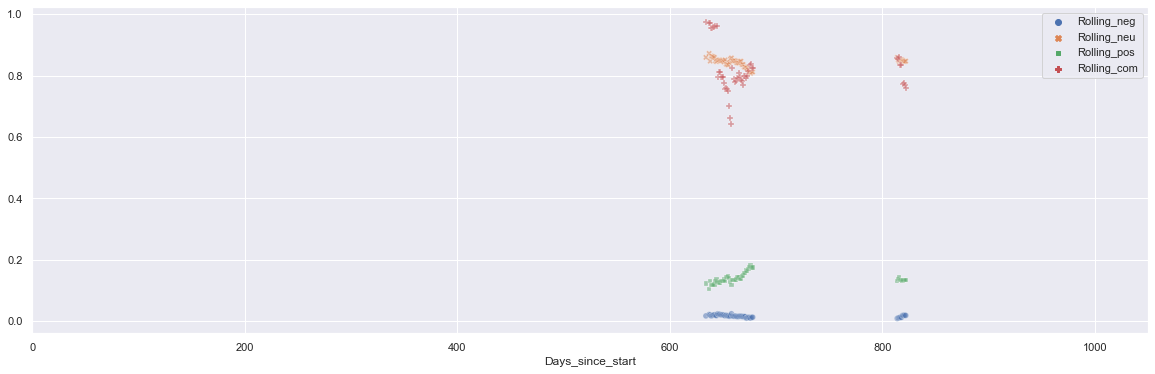

./data/skilling-j/deleted_items


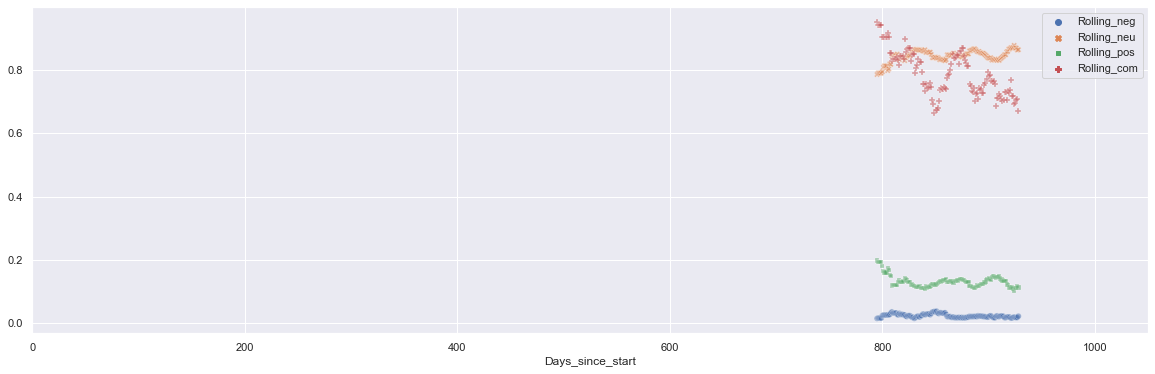

./data/skilling-j/calendar


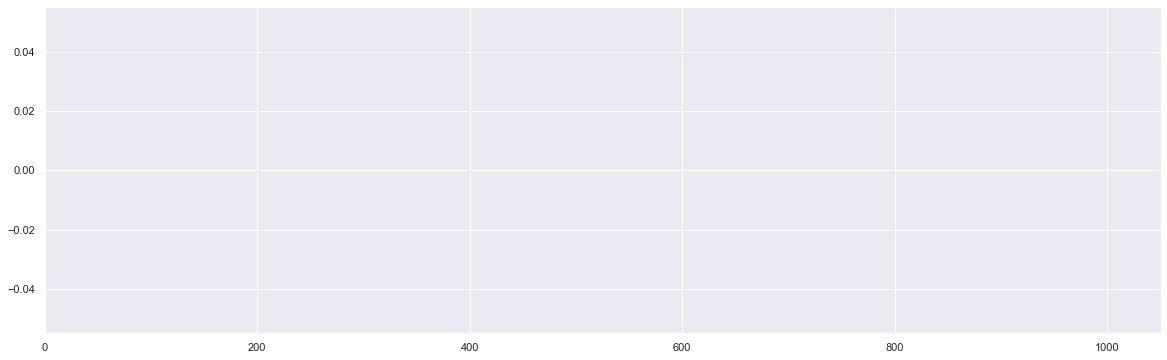

./data/skilling-j/inbox


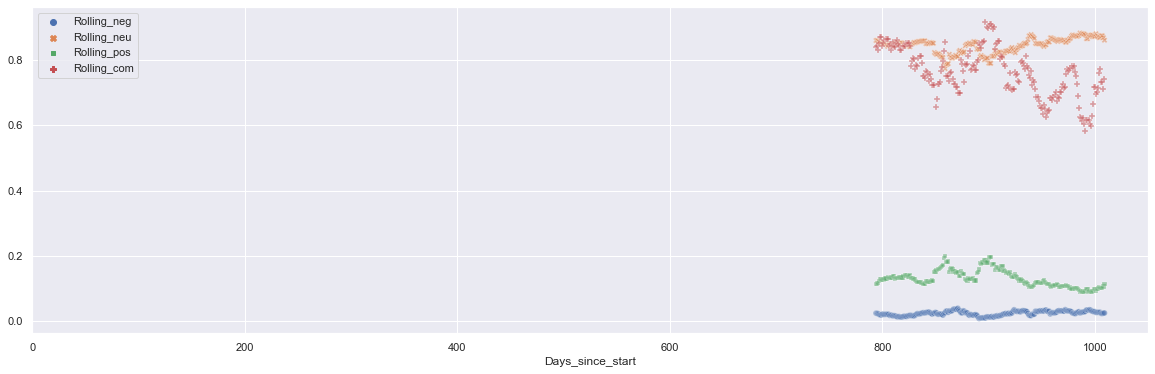

./data/skilling-j/inbox/genie


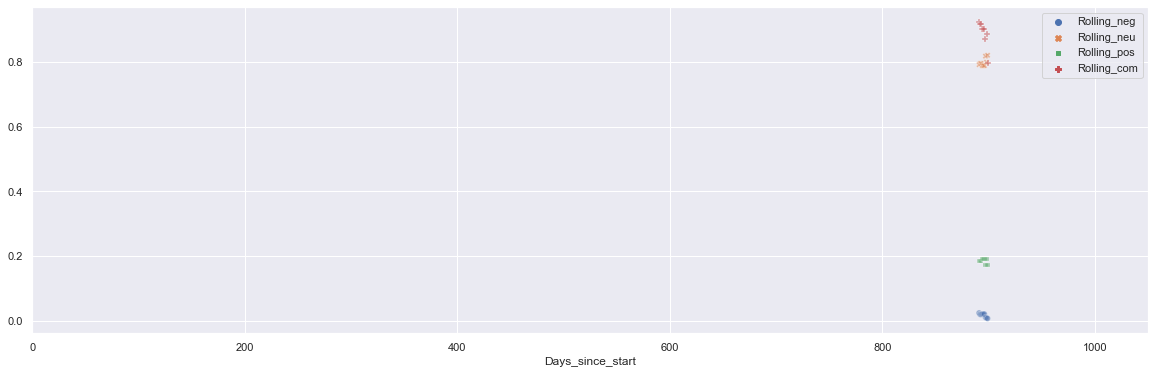

./data/skilling-j/discussion_threads


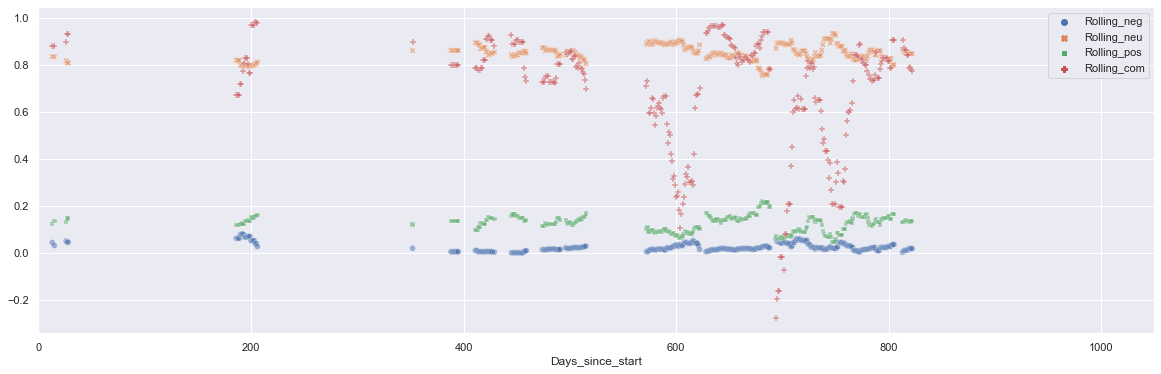

./data/skilling-j/contacts


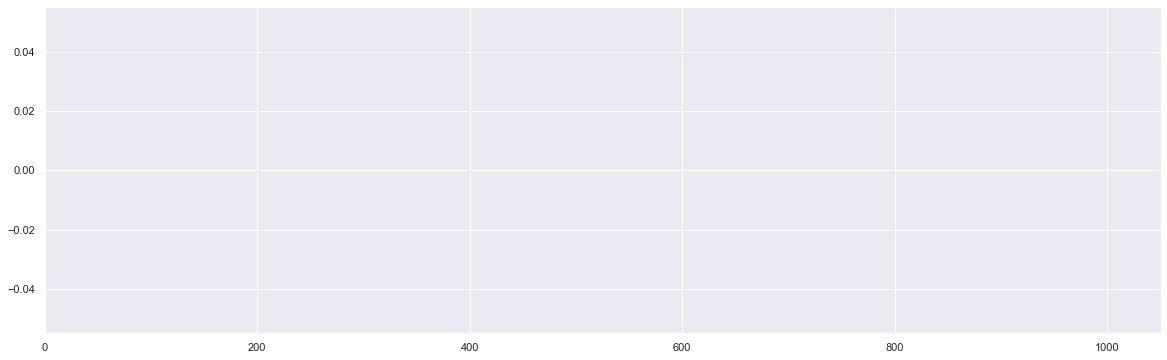

./data/skilling-j/sent_items


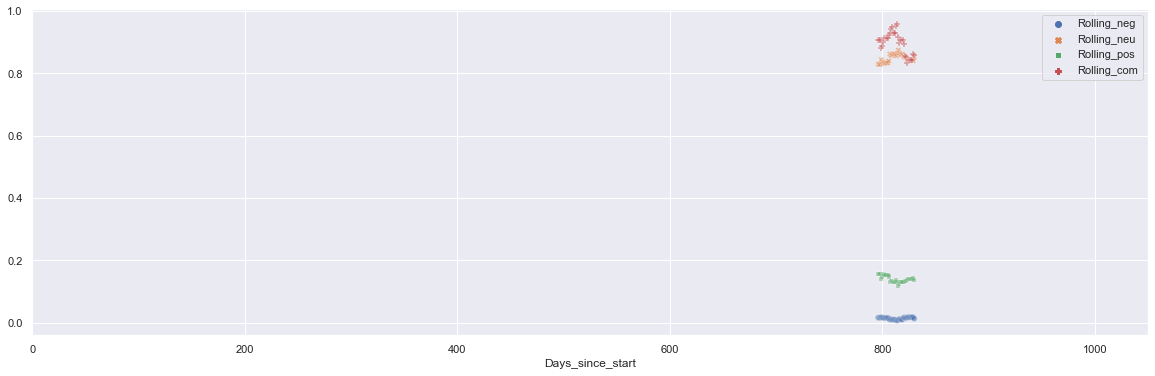

./data/skilling-j/mark


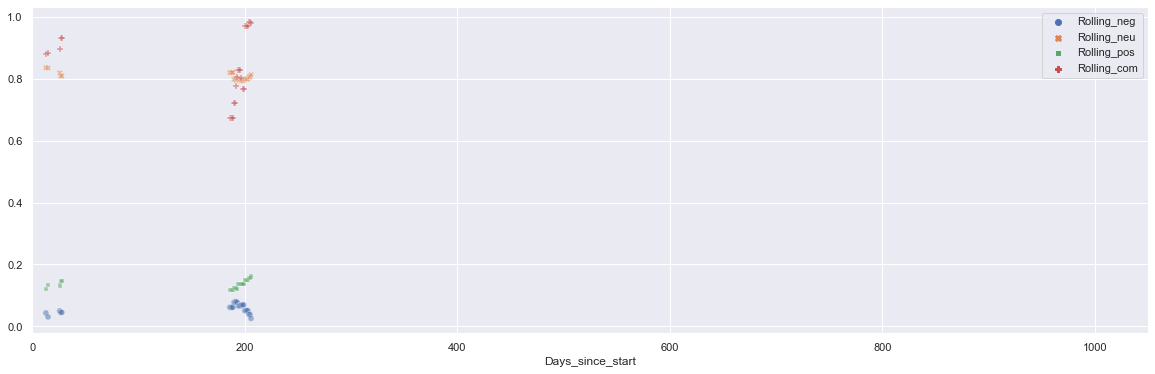

./data/skilling-j/sent


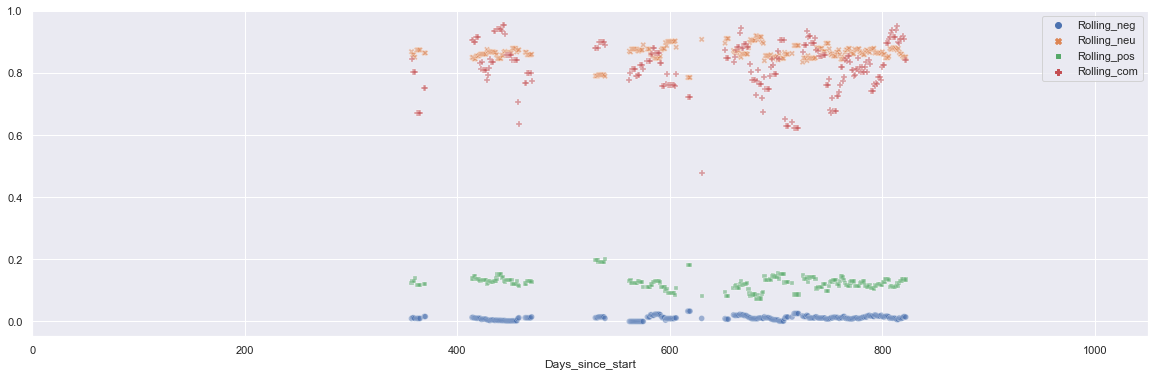

./data/skilling-j/_sent_mail


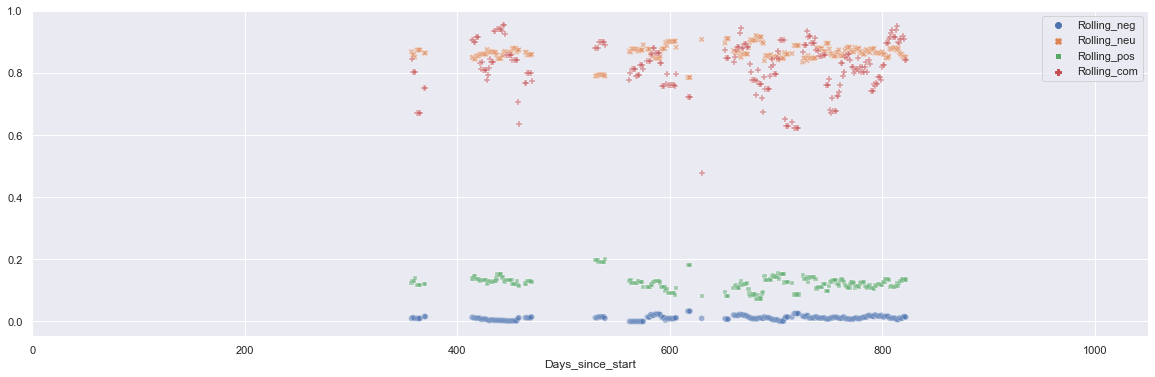

./data/skilling-j/all_documents


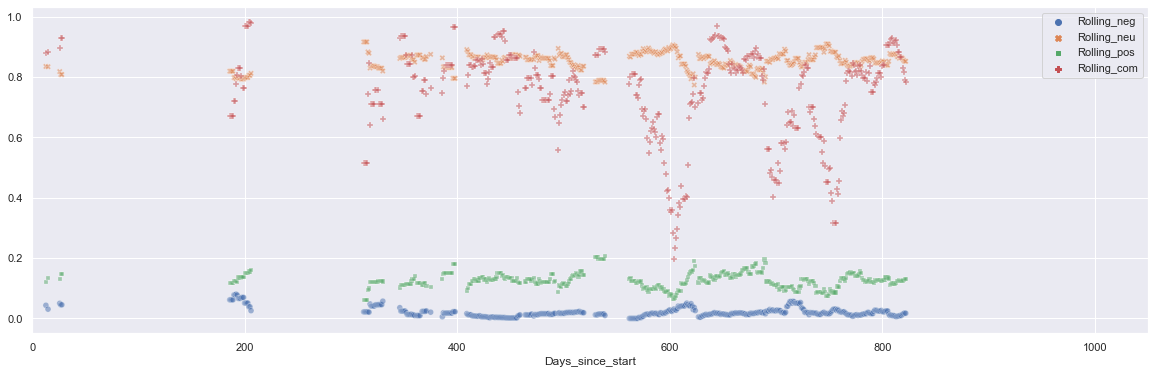

In [6]:
def get_sentiment_rolling_averages(df):
    #set_trace()
    rolling_cols = ['Rolling_neg', 'Rolling_neu', 'Rolling_pos', 'Rolling_com']
    df = df[['Days_since_start', 'Neg_pol', 'Neu_pol', 'Pos_pol', 'Com_pol']]
    df = df.groupby('Days_since_start').mean()
    df = df.reindex(list(range(min(df.index), max(df.index+1))))
    df[rolling_cols] = df[['Neg_pol', 'Neu_pol', 'Pos_pol', 'Com_pol']].rolling(14, min_periods=4).mean()
    return df

# Input: entire featured df, x axis lower bound, x axis upper bound
def plot_rolling_sentiment(df, start, end):
    rolling_cols = ['Rolling_neg', 'Rolling_neu', 'Rolling_pos', 'Rolling_com']
    sns.scatterplot(
        data=df[rolling_cols],
        alpha=.5
    )
    plt.xlim(start, end)
    plt.show()

def analyze_folder_sentiment(df):
    for dir in df['Dir'].unique():
        print(dir)
        dir_df = df[df['Dir']==dir]
        df_rolling = get_sentiment_rolling_averages(dir_df)
        plot_rolling_sentiment(df_rolling, 0, 1050)

analyze_folder_sentiment(resetted_df)

As we can see, the contents of each directory span fairly unique periods of time. This alone gives us reason to analyze them independently, even remaining naive about directory names since it is safer not to make assumptions there.

From these plots we can make several observations:

*  `./inbox_notes/` could easily be segmented into two periods of, presumably, note-taking. Perhaps we can infer something about what was on Mr. Skilling's mind during these periods using term frequency text classification.
*  `./discussion_threads/` has three extremely negative valleys. It would be interesting to identify the source of such negative sentiment.
*  `./inbox/` shows an erratic downward trend in compound sentiment and an up ward trend in neutral sentiment at the expense of positive sentiment following roughly day 890. Let's take a closer look.



## Change Point Detection

Let's focus on compound sentiment, since it is already a representative function of positive, negative, and neutral sentiments. First we convert the `./inbox` rolling average compound sentiment to a stationary series $ y $ by calculating its discrete derivative using the formula

$ y = \Delta f = n \mapsto f(n + 1) - f(n) $

This is useful because it allows us to treat the series as one or more concatenated sequences of independent, identically distributed variables on the interval $ [0, n] $. Suppose at some time $ t $ the function $ f $ changed to function $ f' $ with some non-identical probability density function, (e.g. something affected the sentiment of Mr. Skilling and his correspondents). Then we would expect to observe $ PDF_{f} $ on the interval $ [0, t) $ and $PDF_{f'} $ on the interval $ [t, n] $. Assuming only $ k=1 $ such change occurs, we can calculate the maximum likelihood $ \hat{t} $ by using dynamic programming to solve for it in the loss function:

$ \hat{t}_1, \hat{t}_2,\dots,\hat{t}_K = \arg\min_{t_1,\dots,t_K} V(t_1,t_2,\dots,t_K) $

where

$ V(t_1,t_2,\dots,t_K) := \sum_{k=0}^K\sum_{t=t_k}^{t_{k+1}-1} \|y_t-\bar{y}_{t_k..t_{k+1}}\|^2 $

Estimating $ \hat{t} $ allows us to partition the data into two groups on the intervals $ [0, \hat{t}) $ and $ [\hat{t}, n] $

In [7]:
def analyze_inbox_sentiment(df):
    # Plot rolling sentiment
    df = df[df['Dir']=='./data/skilling-j/inbox']
    df_rolling = get_sentiment_rolling_averages(df)
    # Convert to stationary time series
    df_rolling['stationary'] = df_rolling['Rolling_com'].shift(1)-df_rolling['Rolling_com']
    '''sns.scatterplot(
        data=df_rolling['stationary']
    )'''

    stationary_np = df_rolling['stationary'].fillna(0).to_numpy().reshape(-1,1)
    index_np = df_rolling.index.fillna(0).to_numpy().reshape(-1,1)
    signal_np = np.concatenate((index_np, stationary_np), axis=1)
    change_points_model = ruptures.Dynp().fit(signal_np)
    results = change_points_model.predict(n_bkps=1)
    changepoint = results[0]
    print("changepoint:", changepoint)
    #print(df_rolling.describe())
    #print(df_rolling.index.min()+changepoint)
    return changepoint

t_hat = analyze_inbox_sentiment(resetted_df)
first_datetime = resetted_df[resetted_df['Dir']=='./data/skilling-j/inbox']['Datetime'].min()
last_datetime = resetted_df[resetted_df['Dir']=='./data/skilling-j/inbox']['Datetime'].max()
print('Start date:', first_datetime.date())
print('End date:', last_datetime.date())

t_hat = first_datetime + dt.timedelta(days=t_hat)
print('Date of t_hat:', t_hat.date())

changepoint: 110
Start date: 2001-04-15
End date: 2001-11-19
Date of t_hat: 2001-08-03


## Results

Seen above, we detect an abrupt change in the compound sentiment of Mr. Skilling's inbox on day 110, which is August 3rd, 2001. Were this any other American's inbox we might expect to see such an abrupt change around September 11th, 2001. The events of September 11th may have compounded the decline in compound sentiment in Mr. Skilling's inbox later, but the fact that the change is detected over a month prior suggests a separate event dictating the sentiment: August 3rd is within three days of when Mr. Skilling would have submitted his two-weeks notice, having resigned on August 14th.

*These results suggest that Mr. Skilling's colleagues became aware of Enron's fraudulent accounting and Skillings' impending career implosion around August 3rd, 2001, significantly prior to Skillings' resignation. *

## Conclusion

In this analysis I used unsupervised change point detection, sentiment analysis, and feature engineering to discover anomalies and subgroupings of emails in the given skilling-j dataset, culminating in the partitioning of the dataset into a pre- change point group and a post- change point group. The pre- change point group appears to coincide with the period of time prior to Jeffrey Skilling's colleagues becoming aware of the gravity of Enron's fraudulent accounting, and opposite for the post- change point group. Future work could investigate the topical contents of these emails using document topic classification technqiues (e.g. comparing email vocabulary to known topical corpuses), or simply reading a sample of the emails since we have isolated a reasonably sized (n = 1251) corpus. Similarly, we could use the email addresses in the to/from email fields to graph a social network and investigate which Enron members were most privy to Enron's fraud or most quickly made aware of it.

For the sake of narrative focus I omitted a tangential investigation into the temporal distribution of emails which showed between 2-4% of all emails in the corpus being sent on each of four separate days. I also would like to analyze the sudden drops in discussion thread sentiment around days 600, 700, and 750.

This type of unsupervised clustering and temporal analysis can be applied to numerous other fields interested in the analysis of natural language, including medical billing payment recovery. In targetted investigations like the Enron SEC probe, these data-centric approaches can be used to optimize the deployment of limited human resources. For example if this analysis were present at the time of the probe, it suggests that there may be incriminating information present in emails around August 3rd. In less targetted scenarios like payment recovery this kind of analysis can be used to detect sudden changes in agent behavior, which may warrant deeper investigation. Similarly, automating simple checks like those here that detected dating discrepencies can be used to prevent or recover from transaction-hindering software errors on a very large scale.

I hope you had as much fun reading this as I did writing it. 